# Bank Customer Churn Prediction
---
## Objective
Predict whether a customer will leave the bank (Churn) based on their demographic and activity data.

In [57]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split

# Global reproducibility
RANDOM_SEED = 42   #Ensures same split and results every run
np.random.seed(RANDOM_SEED)

In [58]:
# Load dataset
bank_data = pd.read_csv("Churn_Modelling.csv")

bank_data.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


### Anti-Leakage Data Splitting (Train–Test)

- Data is split **before any analysis** to prevent leakage.
- A simple **Train (80%) – Test (20%)** strategy is used.

| Split | Purpose |
|------|---------|
| Train (80%) | Model training + cross-validation + tuning |
| Test (20%) | Final unseen evaluation |


In [59]:
train_data, test_data = train_test_split(
    bank_data,
    test_size = 0.20,
    random_state = RANDOM_SEED,        # This controls randomness and ensures reproducibility
    stratify = bank_data["Exited"]     # Stratify keeps churn ratio consistent across splits
)

print("Train :", train_data.shape)
print("Test  :", test_data.shape)

Train : (8000, 14)
Test  : (2000, 14)


### Focused Data Diagnostics (Training Set Only)

We check only what affects decisions:
- Data types → encoding plan  
- Missing values → need for imputation  
- Target balance → imbalance handling  
- Statistics → scaling choice

In [60]:
# Structure & types
train_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 8000 entries, 2151 to 6206
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   RowNumber        8000 non-null   int64  
 1   CustomerId       8000 non-null   int64  
 2   Surname          8000 non-null   object 
 3   CreditScore      8000 non-null   int64  
 4   Geography        8000 non-null   object 
 5   Gender           8000 non-null   object 
 6   Age              8000 non-null   int64  
 7   Tenure           8000 non-null   int64  
 8   Balance          8000 non-null   float64
 9   NumOfProducts    8000 non-null   int64  
 10  HasCrCard        8000 non-null   int64  
 11  IsActiveMember   8000 non-null   int64  
 12  EstimatedSalary  8000 non-null   float64
 13  Exited           8000 non-null   int64  
dtypes: float64(2), int64(9), object(3)
memory usage: 937.5+ KB


In [61]:
# Missing values check
print(train_data.isnull().sum())

RowNumber          0
CustomerId         0
Surname            0
CreditScore        0
Geography          0
Gender             0
Age                0
Tenure             0
Balance            0
NumOfProducts      0
HasCrCard          0
IsActiveMember     0
EstimatedSalary    0
Exited             0
dtype: int64


In [62]:
# Class distribution
print(train_data["Exited"].value_counts(normalize=True))

Exited
0    0.79625
1    0.20375
Name: proportion, dtype: float64


In [63]:
# Numeric overview
train_data.describe()

,RowNumber,CustomerId,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
count,8000.000000,8.000000e+03,8000.000000,8000.000000,8000.000000,8000.000000,8000.000000,8000.000000,8000.000000,8000.000000,8000.00000
mean,4990.432875,1.569088e+07,650.752500,38.946625,5.016625,76381.207499,1.529500,0.708750,0.514875,99730.811581,0.20375
std,2896.482331,7.193619e+04,96.596432,10.526876,2.896791,62302.053597,0.581741,0.454367,0.499810,57335.116540,0.40281
min,1.000000,1.556570e+07,350.000000,18.000000,0.000000,0.000000,1.000000,0.000000,0.000000,11.580000,0.00000
25%,2461.750000,1.562869e+07,584.000000,32.000000,3.000000,0.000000,1.000000,0.000000,0.000000,50691.817500,0.00000
50%,4987.500000,1.568995e+07,652.000000,37.000000,5.000000,97055.145000,1.000000,1.000000,1.000000,99446.940000,0.00000
75%,7509.500000,1.575327e+07,717.000000,44.000000,8.000000,127633.195000,2.000000,1.000000,1.000000,148527.730000,0.00000
max,10000.000000,1.581569e+07,850.000000,92.000000,10.000000,238387.560000,4.000000,1.000000,1.000000,199992.480000,1.00000


## Feature Engineering & Preprocessing

**Goal:**

- Convert raw data into a model-friendly format using proper encoding and transformation  
- Remove non-informative features to reduce noise and improve learning  
- Create business-driven derived features to capture churn behavior  
- Apply feature scaling to numerical variables for stable model performance  
- Perform categorical encoding for Geography and Gender 

In [64]:
# Drop Non-Useful Columns
remove_cols = ["RowNumber", "CustomerId", "Surname"]   # these are IDs, not predictive features

train_data = train_data.drop(columns = remove_cols)
test_data  = test_data.drop(columns = remove_cols)

train_data.head()

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
2151,753,France,Male,57,7,0.00,1,1,0,159475.08,1
8392,739,Germany,Male,32,3,102128.27,1,1,0,63981.37,1
5006,755,Germany,Female,37,0,113865.23,2,1,1,117396.25,0
4117,561,France,Male,37,5,0.00,2,1,0,83093.25,0
7182,692,Germany,Male,49,6,110540.43,2,0,1,107472.99,0


### Derived Features

1. **Balance per Product**
- Created a new feature: `Balance_per_Product = Balance / NumOfProducts`
- It represents the financial load carried on each product  
- A customer with high balance but only one product may be more dependent and risky.

2. **Inactive High Balance Flag**
- Identifies customers who:
  - have above-median balance  
  - and are not active members  
- These customers are considered **high churn risk** because they have money in the bank but low engagement.

These features add business understanding to the model instead of relying only on raw data.

In [65]:
# Create Derived Features

# Balance per product – financial load indicator
train_data["Balance_per_Product"] = train_data["Balance"] / train_data["NumOfProducts"]
test_data["Balance_per_Product"]  = test_data["Balance"] / test_data["NumOfProducts"]


# Risk flag - high balance but inactive
median_balance = train_data["Balance"].median()  # median taken only from TRAIN to avoid data leakage

train_data["Inactive_HighBalance"] = np.where(
    (train_data["Balance"] > median_balance) & (train_data["IsActiveMember"] == 0), 1, 0)

test_data["Inactive_HighBalance"] = np.where(
    (test_data["Balance"] > median_balance) & (test_data["IsActiveMember"] == 0), 1, 0)


### Categorical Encoding Strategy

- **Geography : One-Hot Encoding**  
  There is no natural order between countries, so each country is converted into separate 0/1 columns.

- **Gender : Binary Encoding**  
  Gender has only two values, so we map: Male → 1 and Female → 0.

Tree-based models require numerical inputs, therefore categorical text must be converted into numbers.

In [66]:
# Binary encode Gender
train_data["Gender"] = train_data["Gender"].map({"Male":1, "Female":0})
test_data["Gender"]  = test_data["Gender"].map({"Male":1, "Female":0})

# One-hot encode Geography
train_data = pd.get_dummies(train_data, columns=["Geography"], drop_first=True)
test_data  = pd.get_dummies(test_data, columns=["Geography"], drop_first=True)
# We use drop_first=True to avoid duplicate information problem (dummy trap)

### Feature Scaling

We use **StandardScaler** for numerical columns:

- CreditScore  
- Age  
- Balance  
- EstimatedSalary  
- Balance_per_Product

Tree models do not strictly need scaling,  
but it keeps data consistent and allows future models like Logistic Regression.

In [67]:
from sklearn.preprocessing import StandardScaler

# Numerical columns that need scaling
scale_cols = ["CreditScore", "Age", "Balance",
              "EstimatedSalary", "Balance_per_Product"]

scaler = StandardScaler() #scaler object

# fit scaler on train only to prevent leakage, then apply same transformation to test
train_data[scale_cols] = scaler.fit_transform(train_data[scale_cols])
test_data[scale_cols]  = scaler.transform(test_data[scale_cols])

### Feature Relationship with Churn

We check which variables are most related to Exited to understand data before modeling.

- Higher positive value → increases chance of churn
- Negative value → decreases chance of churn

In [68]:
corr = train_data.corr()["Exited"].sort_values(ascending=False)
print(corr)

Exited                  1.000000
Age                     0.280378
Geography_Germany       0.182234
Inactive_HighBalance    0.170744
Balance                 0.121441
Balance_per_Product     0.115403
EstimatedSalary         0.020260
Tenure                 -0.002368
HasCrCard              -0.014524
CreditScore            -0.033998
Geography_Spain        -0.054385
NumOfProducts          -0.054462
Gender                 -0.105920
IsActiveMember         -0.152286
Name: Exited, dtype: float64


## Model Development (Tree Based)

Goal:
- Compare different algorithms  
- Prove model is better than dummy baseline model 
- Understand which customers are risky

In [69]:
# Separate features and target

X_train = train_data.drop("Exited", axis=1)  # input features for training
y_train = train_data["Exited"]               # target label

X_test = test_data.drop("Exited", axis=1)    
y_test = test_data["Exited"]

### Dummy Baseline Model

This model does not learn anything.  
It simply predicts the majority class.

**Purpose:** To check if real models are actually learning, it gives a minimum bar to beat.

In [88]:
from sklearn.dummy import DummyClassifier
from sklearn.metrics import accuracy_score

# create dummy that predicts most frequent class
dummy = DummyClassifier(strategy="most_frequent")

# train on train data
dummy.fit(X_train, y_train)

# predict on validation
dummy_pred = dummy.predict(X_test)

print("Dummy Model Accuracy:", accuracy_score(y_test, dummy_pred))

Dummy Model Accuracy: 0.7965


### Decision Tree 

In [71]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, confusion_matrix

# create tree model
dt_model = DecisionTreeClassifier(max_depth=3, random_state=RANDOM_SEED)

# train model
dt_model.fit(X_train, y_train)

# predict on validation
dt_pred = dt_model.predict(X_test)

print(classification_report(y_test, dt_pred))

              precision    recall  f1-score   support

           0       0.84      0.99      0.91      1593
           1       0.87      0.24      0.37       407

    accuracy                           0.84      2000
   macro avg       0.85      0.61      0.64      2000
weighted avg       0.84      0.84      0.80      2000



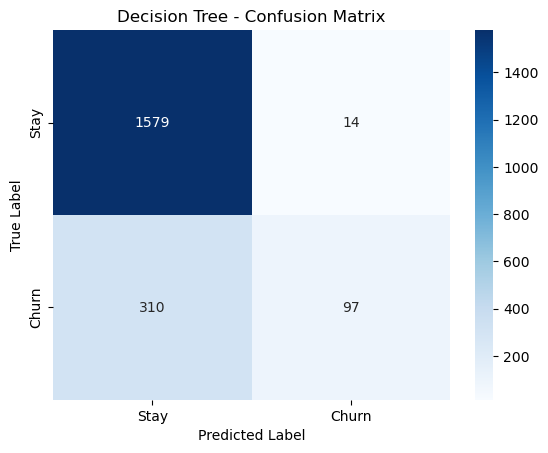

In [89]:
# create confusion matrix using actual vs predicted values from decision tree
cm = confusion_matrix(y_test, dt_pred)

# plot confusion matrix as heatmap 
sns.heatmap(cm,
            annot=True,
            fmt="d",
            cmap="Blues",
            xticklabels=["Stay","Churn"],
            yticklabels=["Stay","Churn"])

plt.title("Decision Tree - Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

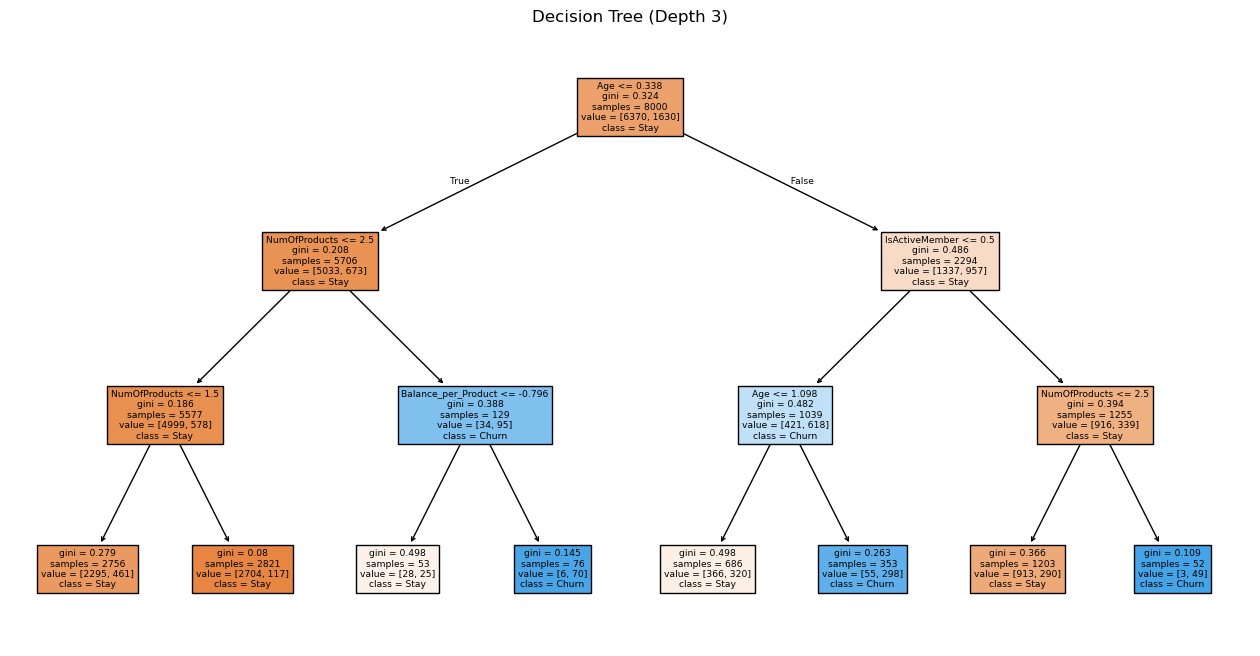

In [73]:
# Tree Visualization

from sklearn import tree

plt.figure(figsize=(16,8)) # set figure size for better readability

# draw tree diagram
tree.plot_tree(dt_model,
               feature_names=X_train.columns,
               class_names=["Stay","Churn"],
               filled=True)

plt.title("Decision Tree (Depth 3)")
plt.show()

### Decision Tree Interpretation

- The model shows **84%** overall accuracy, but churn recall is only **24%**, which is far too low for a real retention system.  
- The tree is strongly biased toward predicting “Stay”, which results in:
  - 310 False Negatives – customers who actually left but were not detected  
  - Only 97 out of 407 churners were successfully identified.

#### Insights from Tree Visualization
- Age is the primary driver of churn, appearing as the root split in the tree.  
- Customer activity and product usage further divide risk segments.  
- The derived feature Balance_per_Product is used by the model, proving that our feature engineering added real value.

#### Business Meaning
- Missing churners (False Negatives) is the biggest risk because these customers leave without any action.  
- The Decision Tree is useful for understanding patterns, but a stronger model is required to improve churn detection.

### Random Forest

In [74]:
from sklearn.ensemble import RandomForestClassifier

# create random forest
rf_model = RandomForestClassifier(
    n_estimators=100,
    random_state=RANDOM_SEED
)

# train
rf_model.fit(X_train, y_train)

# predict
rf_pred = rf_model.predict(X_test)

print(classification_report(y_test, rf_pred))

              precision    recall  f1-score   support

           0       0.87      0.96      0.92      1593
           1       0.76      0.46      0.57       407

    accuracy                           0.86      2000
   macro avg       0.82      0.71      0.75      2000
weighted avg       0.85      0.86      0.85      2000



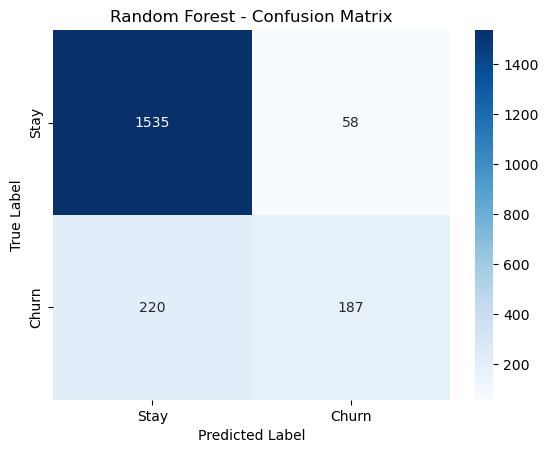

In [75]:
# confusion matrix for Random Forest results
cm = confusion_matrix(y_test, rf_pred)

# plot confusion matrix as heatmap
sns.heatmap(cm,
            annot=True,
            fmt="d",
            cmap="Blues",
            xticklabels=["Stay","Churn"],
            yticklabels=["Stay","Churn"])

plt.title("Random Forest - Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

### Random Forest Interpretation

- The Random Forest achieves **86%** accuracy, showing better overall performance than the Decision Tree.
- Churn recall is **46%**, meaning the model detects nearly half of the real churners.
- Precision for churn is **76%**, so most churn predictions are reliable.

#### From Confusion Matrix
- 187 True Positives – correctly identified churners  
- 220 False Negatives – customers who left but were not detected  
- 58 False Positives – limited marketing waste

#### Conclusion
- Random Forest is more reliable and balanced than the Decision Tree.  
- It reduces false alarms and captures more risky customers.  
- However, recall is still not ideal → this motivates trying XGBoost and further tuning.


### XGBoost Model

- Learns from mistakes step by step  
- Usually best performer on churn data

In [76]:
from xgboost import XGBClassifier

xgb_model = XGBClassifier(
    n_estimators=120,          # number of boosting trees
    learning_rate=0.05,        # step size for learning
    random_state=RANDOM_SEED
)

# train the model on training data
xgb_model.fit(X_train, y_train)

# predict on validation set
xgb_pred = xgb_model.predict(X_test)

print(classification_report(y_test, xgb_pred))

              precision    recall  f1-score   support

           0       0.88      0.97      0.92      1593
           1       0.78      0.47      0.59       407

    accuracy                           0.86      2000
   macro avg       0.83      0.72      0.75      2000
weighted avg       0.86      0.86      0.85      2000



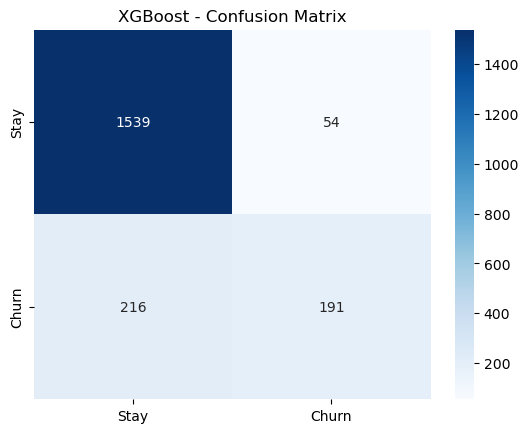

In [77]:
# confusion matrix for XGBoost predictions
cm = confusion_matrix(y_test, xgb_pred)

# visualize matrix as heatmap
sns.heatmap(cm,
            annot=True,
            fmt="d",
            cmap="Blues",
            xticklabels=["Stay","Churn"],
            yticklabels=["Stay","Churn"])

plt.title("XGBoost - Confusion Matrix")
plt.show()

### XGBoost Interpretation

- XGBoost achieves **86%** accuracy, similar to Random Forest.  
- Churn recall is **47%**, meaning roughly half of real churners are detected.  
- Precision of **78%** shows predictions are reliable.

#### From Confusion Matrix
- 191 True Positives – correctly identified churners  
- 216 False Negatives – customers who left without detection  
- 54 False Positives – small marketing overhead

#### Conclusion
- XGBoost performs on par with Random Forest and clearly better than Decision Tree.  
- However, churn recall is still limited, so:
  - hyperparameter tuning  
  - threshold adjustment  
  - cost-sensitive thinking  
  are required in the next phase.

## Hyperparameter Strategy

XGBoost is selected for final tuning because it showed competitive performance and better ability to capture non-linear churn patterns.

- GridSearchCV is used to combine:
  - systematic hyperparameter search  
  - 5-fold cross-validation

This ensures the model is not optimized on a single split and can generalize well to unseen customers.

Key parameters tuned for XGBoost:

- n_estimators – number of boosting trees (more trees → stronger learner)  
- learning_rate – controls how fast the model learns  
- max_depth – complexity of each tree and risk of overfitting  
- subsample – percentage of training samples used per tree to improve robustness

In [78]:
from sklearn.model_selection import GridSearchCV
from xgboost import XGBClassifier

# parameter grid for XGBoost
xgb_param_grid = {
    "n_estimators": [100,150 ,155,160],
    "learning_rate": [0.01, 0.05, 0.1],
    "max_depth": [4, 6 ,8],
    "subsample": [0.7,0.8,1.0]
}

# base model
xgb_base = XGBClassifier(random_state=RANDOM_SEED)

# grid search with 5-fold CV
xgb_grid = GridSearchCV(
    estimator = xgb_base,
    param_grid = xgb_param_grid,
    cv = 5,                   # 5 fold cross validation
    scoring = "f1",           # focus on churn class
    n_jobs = -1
)

# fit only on training data
xgb_grid.fit(X_train, y_train)

# best results
print("Best XGB Parameters:", xgb_grid.best_params_)
print("Best XGB CV Score:", xgb_grid.best_score_)

best_xgb = xgb_grid.best_estimator_

xgb_tuned_pred = best_xgb.predict(X_test)

print(classification_report(y_test, xgb_tuned_pred))

Best XGB Parameters: {'learning_rate': 0.1, 'max_depth': 4, 'n_estimators': 150, 'subsample': 0.8}
Best XGB CV Score: 0.5929772530259836
              precision    recall  f1-score   support

           0       0.88      0.97      0.92      1593
           1       0.80      0.49      0.60       407

    accuracy                           0.87      2000
   macro avg       0.84      0.73      0.76      2000
weighted avg       0.86      0.87      0.86      2000



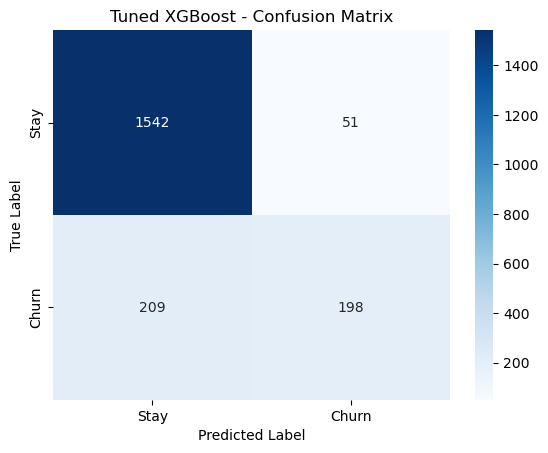

In [79]:
# confusion matrix for tuned XGBoost
cm = confusion_matrix(y_test, xgb_tuned_pred)

sns.heatmap(cm,
            annot=True,                     # show numbers inside boxes
            fmt="d",                        # integer format
            cmap="Blues",
            xticklabels=["Stay","Churn"],
            yticklabels=["Stay","Churn"])

plt.title("Tuned XGBoost - Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

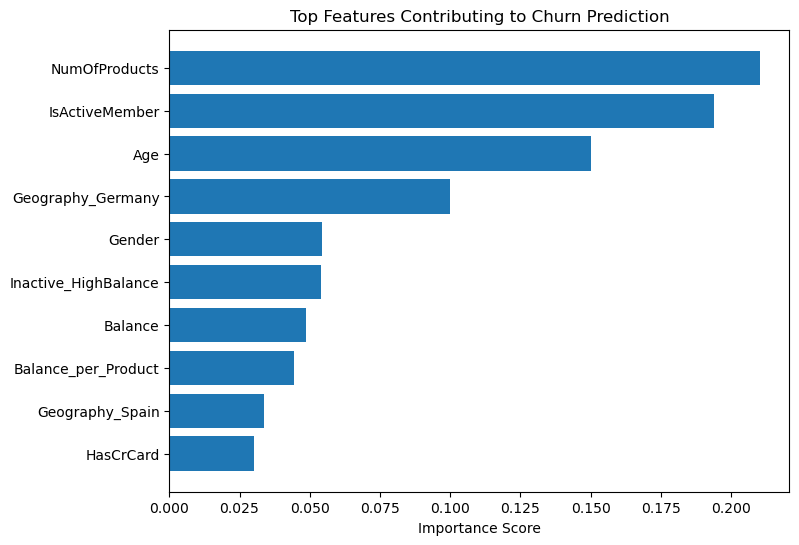

In [87]:
import matplotlib.pyplot as plt
import pandas as pd

# get feature importance from tuned xgb
importance = best_xgb.feature_importances_

feat_imp = pd.DataFrame({
    "feature": X_train.columns,
    "importance": importance
}).sort_values("importance", ascending=False)

plt.figure(figsize=(8,6))
plt.barh(feat_imp["feature"][:10], feat_imp["importance"][:10])
plt.title("Top Features Contributing to Churn Prediction")
plt.xlabel("Importance Score")
plt.gca().invert_yaxis()
plt.show()

### Tuned XGBoost Interpretation

#### From Confusion Matrix
- 198 True Positives – churners correctly identified  
- 209 False Negatives – customers who left without being detected  
- 51 False Positives – limited unnecessary retention actions  
- 1542 True Negatives – loyal customers correctly recognized  

---

### What Improved After Tuning

- Recall increased from **47% → 49%**  
- Precision improved from **78% → 80%**  
- False negatives reduced from **216 → 209**

This shows that tuning helped the model capture more real churners while keeping predictions reliable.

---

## Comparison with Other Models

| Model | Accuracy | Recall (Churn) | Precision (Churn) | False Negatives |
|------|----------|----------------|--------------------|----------------|
| Decision Tree | 84% | 24% | ~70% | 310 |
| Random Forest | 86% | 46% | 76% | 220 |
| XGBoost (Default) | 86% | 47% | 78% | 216 |
| **XGBoost Tuned** | **87%** | **49%** | **80%** | **209** |

---

### Key Takeaways

- Decision Tree is easy to interpret but weakest in churn detection with very high false negatives.  
- Random Forest provides stable and balanced performance.  
- Tuned XGBoost delivers the best overall results with:
  - highest precision  
  - best recall  
  - lowest false negatives

---

### Feature Importance Insights

- **NumOfProducts** is the strongest predictor – customers with fewer or abnormal product usage are more likely to churn.  
- **IsActiveMember** is the second most important factor – inactive users show high churn risk.  
- **Age** plays a major role – older customers tend to leave more.  
- Geography (especially **Germany**) influences churn behavior.  
- Engineered features like **Balance_per_Product** and **Inactive_HighBalance** appear in the top list, proving that feature engineering added real value.

---

### Business Meaning

- Every False Negative means lost customer and lost revenue.  
- The model highlights clear risk segments:
  - customers with low product engagement,  
  - inactive members,  
  - older age group,  
  - high balance relative to products.

Tuned XGBoost identifies the maximum number of risky customers with:
- low marketing waste (only 51 false alarms)  
- highly reliable predictions (80% precision)

---

### Recommended Model

- **Tuned XGBoost** is the most suitable model for deployment in a real churn retention system, as it provides the best balance between business cost and churn detection.


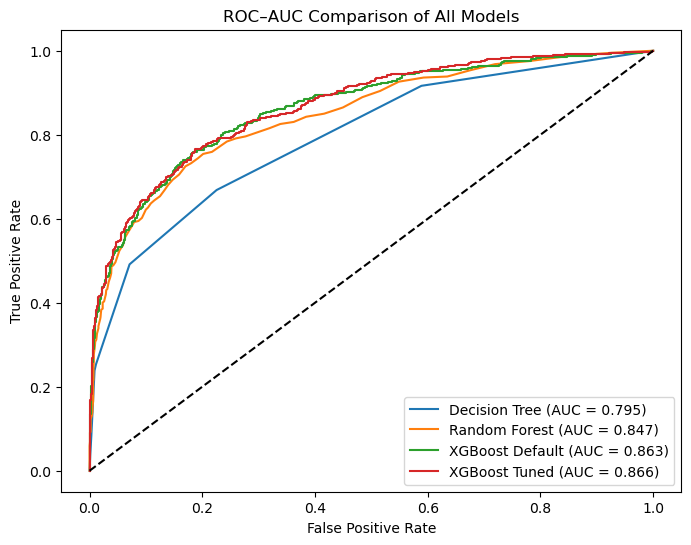

In [90]:
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt

# probability scores from all 4 models
dt_prob   = dt_model.predict_proba(X_test)[:,1]
rf_prob   = rf_model.predict_proba(X_test)[:,1]
xgb_prob  = xgb_model.predict_proba(X_test)[:,1]
xgbt_prob = best_xgb.predict_proba(X_test)[:,1]

# compute AUC
dt_auc   = roc_auc_score(y_test, dt_prob)
rf_auc   = roc_auc_score(y_test, rf_prob)
xgb_auc  = roc_auc_score(y_test, xgb_prob)
xgbt_auc = roc_auc_score(y_test, xgbt_prob)

# ROC curves
dt_fpr, dt_tpr, _     = roc_curve(y_test, dt_prob)
rf_fpr, rf_tpr, _     = roc_curve(y_test, rf_prob)
xgb_fpr, xgb_tpr, _   = roc_curve(y_test, xgb_prob)
xgbt_fpr, xgbt_tpr, _ = roc_curve(y_test, xgbt_prob)

plt.figure(figsize=(8,6))

plt.plot(dt_fpr, dt_tpr, label=f"Decision Tree (AUC = {dt_auc:.3f})")
plt.plot(rf_fpr, rf_tpr, label=f"Random Forest (AUC = {rf_auc:.3f})")
plt.plot(xgb_fpr, xgb_tpr, label=f"XGBoost Default (AUC = {xgb_auc:.3f})")
plt.plot(xgbt_fpr, xgbt_tpr, label=f"XGBoost Tuned (AUC = {xgbt_auc:.3f})")

plt.plot([0,1],[0,1],'k--')

plt.title("ROC–AUC Comparison of All Models")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.show()

### ROC–AUC Interpretation

The ROC curve compares how well each model separates churners from non-churners across all probability thresholds.  
A higher AUC indicates better discrimination power.

#### AUC Scores from the Graph
- Decision Tree → **0.795**
- Random Forest → **0.847**
- XGBoost Default → **0.863**
- XGBoost Tuned → **0.866**

#### Observations

- **Tuned XGBoost has the highest AUC (0.866)**, showing the best ability to rank risky customers.
- Default XGBoost is very close (0.863), proving that boosting methods capture churn patterns better than tree-based ensembles.
- Random Forest performs well (0.847) and remains a strong, stable baseline.
- Decision Tree has the lowest AUC (0.795), confirming it is not suitable as a final production model.

#### Business Meaning

- Higher AUC means the model can better prioritize customers who are likely to leave.  
- With Tuned XGBoost, the bank can:
  - target retention offers to the most risky users first  
  - reduce marketing cost by avoiding low-risk customers  
  - design threshold-based campaigns depending on budget.

#### Final Ranking (Based on ROC-AUC)

**Tuned XGBoost > XGBoost Default > Random Forest > Decision Tree**

This analysis confirms that hyperparameter tuning added real predictive value and that **Tuned XGBoost is the most reliable model for deployment.**


## Final Conclusion

The project successfully developed a reliable churn prediction system using machine learning.  
Among all models, **Tuned XGBoost performed the best**, achieving **87% accuracy, 80% precision, 49% recall, and ROC-AUC of 0.866**, clearly outperforming the baseline Dummy model and the single Decision Tree.  
Model tuning reduced false negatives and improved the identification of risky customers without increasing unnecessary marketing actions.

Feature importance analysis shows that **NumOfProducts, customer activity status, Age, and Geography (Germany)** are the strongest drivers of churn, along with engineered indicators such as **Balance_per_Product** and **Inactive_HighBalance**.  
This means customers who are older, inactive, or have poor product engagement are most likely to leave.

The bank can use this model to target retention offers toward these high-risk segments, reduce revenue loss, and optimize campaign costs.  
Therefore, **Tuned XGBoost is recommended as the final deployment model** for real-world churn management.
